# Introduction
In February 2006, Prosper company started helping people borrow thousands of dollars online from strangers using a peer-to-peer lending system. Individual investors enjoyed the returns (historical return average 5.6%) from the lending, and borrowers enjoyed similar cost advantages compared with rates at a bank or credit union. Prosper alone facilitated \$1.5 billion in Borrower Loan originations during 2020 and \$18.2 billion in Borrower Loan originations since it first launched in 2006.
 
There are many loans on the peer-to-peer lending platform that inventors need to pick to put their money on, which is time-consuming and sometimes unclear which loan to pick. To address this issue, we start building a roboadviser that automatically evaluates loans and advises investors on which loan to put their money on.

To achieve that, we build a model from historical data and use it in roboadviser application to select high-quality loans to save investors time and maximize returns.

In [ ]:
from importlib import reload # TODO remove this block
import sys
#reload(sys.modules['title_parser'])
reload(sys.modules['util'])
#reload(sys.modules['imputer'])

#!pip install string-grouper
#!pip install wordsegment
#!pip install pyspellchecker

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import collections

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Custom python modules used for feature engineering
from encoders import Encoders
from replacenan import ReplaceNaN
from imputer import Imputer
#from title_parser import TitleParser
from util import *

import warnings
#warnings.filterwarnings('ignore')

# The data is located on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

We used LendingClub LLC, a peer-to-peer lending company headquartered in San Francisco, historical loan data which is hosted on [Kaggle](https://www.kaggle.com/wordsforthewise/lending-club). The historical data spans between June 2007 and December 2018.

Since the loan status outcome is also determind by the economic condition, we web scrap seasonally adjusted unemployment data from [U.S. Bureau of Labor Statistic](https://www.bls.gov/charts/state-employment-and-unemployment/state-unemployment-rates-map.htm)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/207-final/lc_loans_2007_to_2018Q4.csv', engine='c', low_memory='False', warn_bad_lines=False)
unemployment = pd.read_csv('/content/drive/My Drive/207-final/state_unemployment.csv', engine='c')
unemployment.set_index('Code', inplace=True)

# Target Classes
This project goal is to build a model that predicts if a given loan at the time of issue will be `Fully Paid` or `Charged Off`. For that reason, we will pick records with only `Fully Paid` and `Charged Off` loan status to extract insight and use it for prediction.

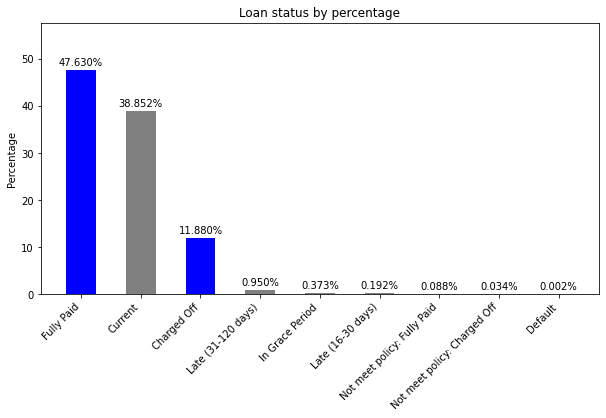

In [ ]:
def show_class_composition(df):
  """Displaying class composition for the given dataset
  Parameters
  ----------
  df : A panda dataset that has "loan_status" feature
  """
  summary = df['loan_status'].value_counts().rename_axis('unique_values').reset_index(name='counts')
  summary['percent'] = (100. * (summary['counts'] / summary['counts'].sum())).round(3)
  summary['unique_values'] = summary['unique_values'].replace(
      ['Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'],
      ['Not meet policy: Fully Paid', 'Not meet policy: Charged Off'])
  colors = ['blue', 'gray', 'blue', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']
  plt.rcParams["figure.figsize"] = [10, 5]
  fig, ax = plt.subplots()
  pps = ax.bar(summary['unique_values'], summary['percent'], width=0.5, align='center', color=colors)
  ax.set_ylim([0, summary['percent'].max()+10])
  plt.xticks(rotation=45, ha='right')
  # Putting percentage value on top of each bar
  for p in pps:
    y = p.get_height()
    ax.text(x=p.get_x()+p.get_width()/2, y=y+1, s="{:.3f}%".format(y), ha='center')
  ax.set_title("Loan status by percentage")
  ax.set_ylabel("Percentage")
  plt.show()

show_class_composition(df)

# Data cleanup

We have 151 features out of which 19 of them are introduced on September 2012 and 14 features are introduced on January 2016. Since the feature value is NaN before the introduction of the new features, we removed all records before January 2016.

Features introduced on September 2012: `total_rev_hi_lim`, `avg_cur_bal`, `mo_sin_old_rev_tl_op`, `mo_sin_rcnt_rev_tl_op`, `mo_sin_rcnt_tl`, `num_accts_ever_120_pd`, `num_actv_bc_tl`, `num_actv_rev_tl`, `num_bc_tl`, `num_il_tl`, `num_op_rev_tl`, `num_rev_accts`, `num_rev_tl_bal_gt_0`, `num_tl_30dpd`, `num_tl_90g_dpd_24m`, `num_tl_op_past_12m`, `pct_tl_nvr_dlq`, `tot_hi_cred_lim`, and `total_il_high_credit_limit`

Features introduced on January 2016: `open_acc_6m`, `open_act_il`, `open_il_12m`, `open_il_24m`, `1-mths_since_rcnt_il`, `total_bal_il`, `open_rv_12m`, `open_rv_24m`, `max_bal_bc`, `all_util`, `inq_fi`, `total_cu_tl`, `inq_last_12m`, and `il_util`

We didn't add description for each feature to keep the notebook concise but the data dictionery is available [here](data/LCDataDictionary.xlsx)

In [ ]:
# Initialing objects that will be used for feature engineering
encoders = Encoders()
replaceNaN = ReplaceNaN()
imputer = Imputer()
scaler = StandardScaler()
vectorizer = TfidfVectorizer(stop_words='english', max_features = 100)# min_df=0.1)
titleParser = TitleParser()
df_records = {}
df_features = {}

df_records["Original"] = df.shape[0]
df_features["Original"] = df.shape[1]
# Removing loans other than "Fully Paid" and "Charged Off"
df_clean = remove_invalid_rows(df)
df_records["After invalid rows removed"] = df_clean.shape[0]
df_clean = convert_to_date(df_clean) # String datatype to datetime conversion
# Taking data starting from January 2016 based on the above reason
df_clean = get_data_since(df_clean, datetime.date(2016, 1, 1))

# The following three feature generators do mapping from one column to another column
df_clean = add_issue_date_feature(df_clean) # Date to integer converion
df_clean = add_unemployment_rate(unemployment, df_clean)
df_clean = months_since_earliest_cr_line(df_clean)
df_features["After generating new features"] = df_clean.shape[1]
df_clean = remove_features(df_clean)
df_records["After removing data before Jan 2016"] = df_clean.shape[0]
df_features["After removing features"] = df_clean.shape[1]

# Splitting the data into training, dev and test
train_data, dev_data, test_data = split_data(df_clean)

# Replaces some known features NaN value with 0 value
# We performed analysis on each feature to identify which NaN represents 0
train_data = replaceNaN.fit_transform(train_data)
dev_data = replaceNaN.transform(dev_data)

# Encode categorical features
encode_features = ['home_ownership', 'verification_status', 'purpose',
                   'application_type', 'term', 'grade', 'sub_grade', 'emp_length',
                   'initial_list_status', 'disbursement_method', 'loan_status']
train_data = encoders.fit_transform(train_data, encode_features)
dev_data = encoders.transform(dev_data)
df_features["After Categorical Encoding"] = train_data.shape[1]

# Splitting into Matrix and Label
train_data, train_label = get_ML(train_data, 'loan_status=Fully Paid')
dev_data, dev_label = get_ML(dev_data, 'loan_status=Fully Paid')

# It uses KNN to impute NaN values
train_data = imputer.fit_transform(train_data)
dev_data = imputer.transform(dev_data)
#test_data = imputer.transform(test_data)

# Saving memory
train_title_matrix = None
dev_title_matrix = None

# Since regularized methods apply a penalty to the coefficients, we need to ensure our coefficients are on a common scale.
scaled_train_data = scaler.fit_transform(train_data)
scaled_dev_data = scaler.transform(dev_data)
# Converting from ndarray type to panda dataframe type
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_dev_data = pd.DataFrame(scaled_dev_data, columns=dev_data.columns)

# min/max scaler
min_max_scaler = MinMaxScaler()
min_max_scaled_train_data = min_max_scaler.fit_transform(train_data)
min_max_scaled_dev_data = min_max_scaler.transform(dev_data)
min_max_scaled_train_data = pd.DataFrame(min_max_scaled_train_data, columns=train_data.columns)
min_max_scaled_dev_data = pd.DataFrame(min_max_scaled_dev_data, columns=dev_data.columns)

# Features and Records size summary

In [ ]:
# Total records size summary
pd.DataFrame.from_dict(df_records, orient='index', columns=['Record Size']).style.format('{:,}')

,Record Size
Original,"2,260,701"
After invalid rows removed,"1,345,310"
After removing data before Jan 2016,"490,309"


In [ ]:
# Feature size summary
pd.DataFrame.from_dict(df_features, orient='index', columns=['Features Size'])

,Features Size
Original,151
After generating new features,155
After removing features,89
After Categorical Encoding,151


In [ ]:
# Sample data
pd.set_option('display.max_columns', None)
train_data[:3]

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_year,issue_month,unemployment_rate,earliest_cr_line_months,home_ownership=MORTGAGE,home_ownership=NONE,home_ownership=OWN,home_ownership=RENT,verification_status=Source Verified,verification_status=Verified,purpose=credit_card,purpose=debt_consolidation,purpose=home_improvement,purpose=house,purpose=major_purchase,purpose=medical,purpose=moving,purpose=other,purpose=renewable_energy,purpose=small_business,purpose=vacation,purpose=wedding,application_type=Joint App,term= 60 months,grade=B,grade=C,grade=D,grade=E,grade=F,grade=G,sub_grade=A2,sub_grade=A3,sub_grade=A4,sub_grade=A5,sub_grade=B1,sub_grade=B2,sub_grade=B3,sub_grade=B4,sub_grade=B5,sub_grade=C1,sub_grade=C2,sub_grade=C3,sub_grade=C4,sub_grade=C5,sub_grade=D1,sub_grade=D2,sub_grade=D3,sub_grade=D4,sub_grade=D5,sub_grade=E1,sub_grade=E2,sub_grade=E3,sub_grade=E4,sub_grade=E5,sub_grade=F1,sub_grade=F2,sub_grade=F3,sub_grade=F4,sub_grade=F5,sub_grade=G1,sub_grade=G2,sub_grade=G3,sub_grade=G4,sub_grade=G5,emp_length=1 year,emp_length=10+ years,emp_length=2 years,emp_length=3 years,emp_length=4 years,emp_length=5 years,emp_length=6 years,emp_length=7 years,emp_length=8 years,emp_length=9 years,emp_length=< 1 year,initial_list_status=w,disbursement_method=DirectPay
0,2000.0,9.16,63.75,23000.0,22.03,0.0,665.0,669.0,1.0,0.0,0.0,5.0,0.0,2012.0,64.9,8.0,0.0,0.0,0.0,1042.0,9494.0,1.0,2.0,0.0,0.0,47.0,7482.0,39.0,1.0,2.0,1547.0,43.0,3100.0,0.0,0.0,1.0,2.0,1899.0,451.0,78.5,0.0,0.0,157.0,47.0,5.0,5.0,0.0,19.0,0.0,5.0,0.0,2.0,2.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,5.0,0.0,0.0,0.0,1.0,75.0,50.0,0.0,0.0,22191.0,9494.0,2100.0,19091.0,2016.0,2.0,5.3,157.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,8400.0,6.97,259.26,120000.0,33.32,0.0,730.0,734.0,2.0,0.0,0.0,21.0,0.0,36632.0,46.2,44.0,0.0,0.0,0.0,0.0,517208.0,3.0,7.0,1.0,4.0,11.0,113609.0,69.0,2.0,3.0,9611.0,58.0,79300.0,0.0,0.0,6.0,8.0,24629.0,29121.0,45.1,0.0,0.0,164.0,163.0,3.0,3.0,4.0,3.0,0.0,4.0,0.0,0.0,3.0,6.0,7.0,15.0,20.0,12.0,20.0,6.0,21.0,0.0,0.0,0.0,4.0,100.0,14.3,0.0,0.0,623011.0,150241.0,53000.0,167899.0,2016.0,2.0,4.7,164.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,35000.0,14.46,822.76,450000.0,27.86,0.0,670.0,674.0,0.0,43.0,0.0,19.0,0.0,308562.0,85.0,38.0,0.0,0.0,0.0,0.0,1298642.0,0.0,4.0,0.0,2.0,14.0,137384.0,75.0,0.0,0.0,21137.0,85.0,364961.0,0.0,0.0,2.0,3.0,68349.0,9129.0,95.0,0.0,0.0,131.0,301.0,59.0,13.0,4.0,59.0,43.0,3.0,43.0,0.0,11.0,12.0,14

# Class composition
The data has a class imbalance problem that can potentially lead to poor model performance specifically for the minority class. To address that issue, we expermented with different subsampling for training data including up-sampling, SMOTE and ROSE methods. We get similar results and go with the simpler version which is up-sampling.

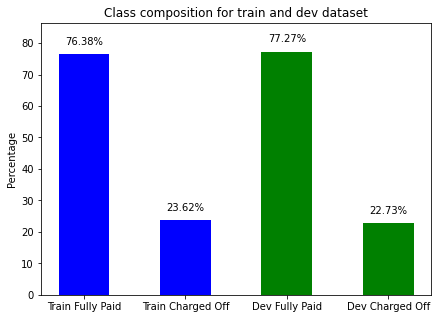

In [ ]:
def show_class_frequencies(train_label, dev_label):
  """Bar plot to show the composition of classes in the training and dev dataset
  Parameters
  ----------
  train_label : Label data for training dataset
  dev_label : Label data for dev dataset
  """
  # Generating summary data for each class
  status_count_train = train_label.value_counts()
  status_count_dev = dev_label.value_counts()
  plt.rcParams["figure.figsize"] = [7, 5]
  fully_paid_train = ((status_count_train[1]/len(train_label))*100)
  charged_off_train = ((status_count_train[0]/len(train_label))*100)
  fully_paid_dev = ((status_count_dev[1]/len(dev_label))*100)
  charged_off_dev = ((status_count_dev[0]/len(dev_label))*100)
  y = [fully_paid_train, charged_off_train, fully_paid_dev, charged_off_dev]
  x = ['Train Fully Paid', 'Train Charged Off', 'Dev Fully Paid', 'Dev Charged Off']

  fig, ax = plt.subplots()
  pps = ax.bar(x, y, width=0.5, align='center', color=['b', 'b', 'g', 'g'])
  ax.set_ylim([0, fully_paid_train+10])
  # Putting percentage value on top of each bar
  for p in pps:
    y = p.get_height()
    ax.text(x=p.get_x()+p.get_width()/2, y=y+3, s="{:.2f}%".format(y), ha='center')
  ax.set_title("Class composition for train and dev dataset")
  ax.set_ylabel("Percentage")
  plt.show()

show_class_frequencies(train_label, dev_label)

# Model building
When the roboadvisor application advises investors on which loan to put their money on, it needs to sort out loans based on investor risk tolerance level.

To balance the risk and reward expectations of the roboadvisor application, we will focus on probabilistic models, including Naive Bayes, Logistic regression, and Gaussian Mixture Model.

## Gaussian Naive Bayes (GaussianNB)
Following the principle of parsimony, our first model that we picked is the simplest one which is a GaussianNB. Unfortunatelly the error rate in the trainig data is very high indcating that there is a high bias that needs to be addressed using complex algorithms, boosting, and/or adding new features.

In [ ]:
def build_gaussian_nb(train_data, train_label, dev_data, dev_label):
  """Building a Gaussian Naive Bayes (GaussianNB) model"""
  # Initializing variables
  smoothings, dev_f1_scores, train_f1_scores = [], [], []
  dev_accuracy_scores, train_accuracy_scores = [], []
  best_clf, dev_best_f1, best_smoothing = None, 0, 0
  # Addressing class imbalance issue
  train_x, train_y = up_sample(train_data, train_label)
  # Building a model and picking the best smoothing
  for smoothing in [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.1]:
    clf = GaussianNB(var_smoothing=smoothing)
    clf.fit(train_x, train_y)
    # Metrics collection
    dev_f1_score, dev_accuracy_score, train_f1_score, train_accuracy_score = \
      get_scores(clf, train_data, train_label, dev_data, dev_label)
    dev_f1_scores.append(dev_f1_score)
    train_f1_scores.append(train_f1_score)
    dev_accuracy_scores.append(dev_accuracy_score)
    train_accuracy_scores.append(train_accuracy_score)
    smoothings.append(smoothing)
    # Finding the best smoothing hyperparameter
    if dev_f1_score > dev_best_f1:
      dev_best_f1, best_smoothing, best_clf = dev_f1_score, smoothing, clf
  # Displaying the findings
  scores = pd.DataFrame({'Smoothing': smoothings, 'Dev F1 Score': dev_f1_scores,
    'Dev Accuracy Score': dev_accuracy_scores, 'Train F1 Score': train_f1_scores,
    'Train Accuracy Score': train_accuracy_scores})
  print("F1 score for different smoothing")
  display(scores)
  print(f"Best smoothing is {best_smoothing} resulting {dev_best_f1} F1 Score")
  
  return best_clf

gaussian_nb_clf = build_gaussian_nb(train_data, train_label, dev_data, dev_label)

F1 score for different smoothing


,Smoothing,Dev F1 Score,Dev Accuracy Score,Train F1 Score,Train Accuracy Score
0,0.00001,0.390,0.384,0.362,0.378
1,0.00010,0.395,0.387,0.364,0.379
2,0.00100,0.400,0.390,0.366,0.380
3,0.00500,0.379,0.379,0.350,0.371
4,0.01000,0.365,0.372,0.339,0.366
5,0.10000,0.339,0.358,0.324,0.358


Best smoothing is 0.001 resulting 0.4 F1 Score


## Logistic Regression

Our next model selection is a Logistic Regression. We built two version of Logistic Regression. The first model is by using L2 penality exclusively and the second model is by combining L1 and L2 penality.

In [ ]:
def logistic_regression_with_l2(train_data, train_label, dev_data, dev_label):
  """Building logestic regression model with L2 penality"""
  # Initializing variables
  strengths, dev_f1_scores, train_f1_scores = [], [], []
  dev_accuracy_scores, train_accuracy_scores = [], []
  best_clf, dev_best_f1, best_strength = None, 0, 0
  regularization = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001]
  # Addressing class imbalance issue
  train_x, train_y = up_sample(train_data, train_label)
  # Evaluating Logistic Regression for each regularization C and L1 ratio
  for i, c in enumerate(regularization):
    np.random.seed(0)
    clf = LogisticRegression(C=c, tol=0.001, n_jobs = -1)
    clf.fit(train_x, train_y)
    # Metrics collection
    dev_f1_score, dev_accuracy_score, train_f1_score, train_accuracy_score = \
      get_scores(clf, train_x, train_y, dev_data, dev_label)
    dev_f1_scores.append(dev_f1_score)
    train_f1_scores.append(train_f1_score)
    dev_accuracy_scores.append(dev_accuracy_score)
    train_accuracy_scores.append(train_accuracy_score)
    strengths.append(c)
    # Finding the best strength hyperparameter
    if dev_f1_score > dev_best_f1:
      dev_best_f1, best_strength, best_clf = dev_f1_score, c, clf
  # Displaying the findings
  scores = pd.DataFrame({'Strength': strengths, 'Dev F1 Score': dev_f1_scores,
    'Dev Accuracy Score': dev_accuracy_scores, 'Train F1 Score': train_f1_scores,
    'Train Accuracy Score': train_accuracy_scores})
  print("F1 score for different smoothing")
  display(scores)
  print(f"Best strength is {best_strength} resulting {dev_best_f1} F1 Score")
  
  return best_clf

lr_l2_clf = logistic_regression_with_l2(scaled_train_data.copy(), train_label.copy(), scaled_dev_data.copy(), dev_label.copy())

F1 score for different smoothing


,Strength,Dev F1 Score,Dev Accuracy Score,Train F1 Score,Train Accuracy Score
0,1.000000e-08,0.706,0.616,0.618,0.643
1,1.000000e-07,0.745,0.650,0.645,0.644
2,1.000000e-06,0.744,0.650,0.647,0.648
3,1.000000e-05,0.738,0.647,0.648,0.653
4,1.000000e-04,0.733,0.644,0.650,0.657


Best strength is 1e-07 resulting 0.745 F1 Score


The following Logestic Regression model uses both L1 and L2 penality. We use L1 for feature selection and then L2 regularize the model which is based on selected features.

In [ ]:
def logistic_regression_with_l1_and_l2(train_data, train_label, dev_data, dev_label):
  """Logestic Regression with L1 and L2 penality"""
  # Initializing variables
  features_size, l1_strengths, l2_strengths = [], [], []
  dev_f1_scores, train_f1_scores = [], []
  dev_accuracy_scores, train_accuracy_scores = [], []
  best_clf, dev_best_f1, best_l1_strength, best_l2_strength, best_feature_size = None, 0, 0, 0, 0
  best_features = []
  regularization = {0.00005:0.01, 0.00025:0.1, 0.0005:0.1, 0.001:0.1, 0.01:1}
  # Addressing class imbalance issue
  train_x, train_y = up_sample(train_data, train_label)
  # Performing feature selection and model building
  for l1_c in regularization:
    np.random.seed(0)
    selected_cols = []
    col_names = train_x.columns
    lr_model_l1 = LogisticRegression(C=l1_c, solver="liblinear", multi_class="auto", penalty="l1", tol=0.001)
    lr_model_l1.fit(train_x, train_y)
    # Identifying features with 0 weight
    for index in range(0, train_x.shape[1]):
      if np.any(lr_model_l1.coef_[:,index]): # Check if the feature has non-zero weight
        selected_cols.append(col_names[index])

    train_data_reduced = train_x.loc[:,selected_cols]
    dev_data_reduced = dev_data.loc[:,selected_cols]

    np.random.seed(0)
    # Building Logistic Regression based on the newly identified features
    lr_model_l2 = LogisticRegression(C=regularization[l1_c], solver="liblinear", multi_class="auto", penalty="l2", tol=0.001)
    lr_model_l2.fit(train_data_reduced, train_y)
    # Metrics collection
    dev_f1_score, dev_accuracy_score, train_f1_score, train_accuracy_score = \
      get_scores(lr_model_l2, train_data_reduced, train_y, dev_data_reduced, dev_label)
    dev_f1_scores.append(dev_f1_score)
    train_f1_scores.append(train_f1_score)
    dev_accuracy_scores.append(dev_accuracy_score)
    train_accuracy_scores.append(train_accuracy_score)
    l1_strengths.append(l1_c)
    l2_strengths.append(regularization[l1_c])
    features_size.append(len(selected_cols))
    # Finding the best strength hyperparameter
    if dev_f1_score > dev_best_f1:
      dev_best_f1, best_l1_strength, best_l2_strength, best_clf = dev_f1_score, l1_c, regularization[l1_c], lr_model_l2
      best_feature_size, best_features = len(selected_cols), selected_cols
  # Displaying the findings
  scores = pd.DataFrame({'L1 Strength': l1_strengths, 'Features Size': features_size, 'L2 Strength': l2_strengths,
    'Dev F1 Score': dev_f1_scores, 'Dev Accuracy Score': dev_accuracy_scores, 'Train F1 Score': train_f1_scores,
    'Train Accuracy Score': train_accuracy_scores})
  print("F1 score for different L1 & L2 strength")
  display(scores)
  print(f"Best L1 Strength is {best_l1_strength} and L2 Strength is {best_l2_strength} with {best_feature_size} feature size resulting {dev_best_f1} F1 Score")
  
  return (best_clf, best_features)

lr_l1_l2_clf, best_features = logistic_regression_with_l1_and_l2(scaled_train_data.copy(), train_label.copy(), scaled_dev_data.copy(), dev_label.copy())

F1 score for different L1 & L2 strength


,L1 Strength,Features Size,L2 Strength,Dev F1 Score,Dev Accuracy Score,Train F1 Score,Train Accuracy Score
0,0.00005,4,0.01,0.730,0.637,0.643,0.638
1,0.00025,32,0.10,0.742,0.652,0.648,0.652
2,0.00050,57,0.10,0.740,0.650,0.648,0.655
3,0.00100,90,0.10,0.740,0.651,0.651,0.658
4,0.01000,135,1.00,0.719,0.632,0.651,0.658


Best L1 Strength is 0.00025 and L2 Strength is 0.1 with 32 feature size resulting 0.742 F1 Score


## Gaussian Mixture Model (GMM)

In [ ]:
def GMM(train_data, train_label, dev_data, dev_label):
  """Building a model using GMM"""
  # Initializing variables
  covariance_types, components, best_dev_predict = [], [], []
  dev_f1_scores, train_f1_scores = [], []
  dev_accuracy_scores, train_accuracy_scores = [], []
  best_charged_off_clf, best_fully_paid_clf = None, None
  best_components, best_covariance_type, dev_best_f1 = 0, 0, 0
  regularization = {"full":[1,2,3,4], "tied": [3], "diag": [8]}

  # Addressing class imbalance issue
  train_data, train_label = up_sample(train_data, train_label)
  charged_off = train_data[train_label == 0]
  fully_paid = train_data[train_label == 1]
  
  # Performing feature selection and model building
  for co_type in regularization:
    for c in regularization[co_type]:
      gmm_charged_off = GaussianMixture(n_components=c, covariance_type=co_type, random_state=0)
      gmm_charged_off.fit(charged_off)
      gmm_fully_paid  = GaussianMixture(n_components=c, covariance_type=co_type, random_state=0)
      gmm_fully_paid.fit(fully_paid)

      # Get probability of each class for dev
      charged_off_likelihood = gmm_charged_off.score_samples(dev_data)
      dev_fully_paid_likelihood = gmm_fully_paid.score_samples(dev_data)
      dev_predict = dev_fully_paid_likelihood > charged_off_likelihood
      # Get probability of each class for train
      charged_off_likelihood = gmm_charged_off.score_samples(train_data)
      fully_paid_likelihood = gmm_fully_paid.score_samples(train_data)
      train_predict = fully_paid_likelihood > charged_off_likelihood

      # Metrics collection
      dev_f1_score = round(metrics.f1_score(dev_label, dev_predict), 3)
      dev_accuracy_score = round(metrics.accuracy_score(dev_label, dev_predict), 3)
      train_f1_score = round(metrics.f1_score(train_label, train_predict), 3)
      train_accuracy_score = round(metrics.accuracy_score(train_label, train_predict), 3)
      dev_f1_scores.append(dev_f1_score)
      train_f1_scores.append(train_f1_score)
      dev_accuracy_scores.append(dev_accuracy_score)
      train_accuracy_scores.append(train_accuracy_score)
      covariance_types.append(co_type)
      components.append(c)
      
      # Finding the best hyperparameters based on F1 score
      if dev_f1_score > dev_best_f1:
        dev_best_f1, best_components, best_covariance_type = dev_f1_score, c, co_type
        best_charged_off_clf, best_fully_paid_clf = gmm_charged_off, gmm_fully_paid
        best_dev_predict = dev_fully_paid_likelihood
  # Displaying the findings
  scores = pd.DataFrame({'Covariance Type': covariance_types, 'Components': components, 'Dev F1 Score': dev_f1_scores,
    'Dev Accuracy Score': dev_accuracy_scores, 'Train F1 Score': train_f1_scores, 'Train Accuracy Score': train_accuracy_scores})
  print("F1 score for different GMM")
  display(scores)
  print(f"Best Covariance Type is {best_covariance_type} and Components is {best_components} resulting {dev_best_f1} F1 Score")

  return (best_charged_off_clf, best_fully_paid_clf, best_dev_predict)

gmm_fully_paid_clf, gmm_charged_off_clf, gmm_dev_predict = GMM(train_data.copy(), train_label.copy(), dev_data.copy(), dev_label.copy())


F1 score for different GMM


,Covariance Type,Components,Dev F1 Score,Dev Accuracy Score,Train F1 Score,Train Accuracy Score
0,full,1,0.789,0.692,0.669,0.633
1,full,2,0.840,0.739,0.668,0.558
2,full,3,0.849,0.748,0.671,0.548
3,full,4,0.758,0.652,0.623,0.592
4,tied,3,0.828,0.730,0.680,0.601
5,diag,8,0.825,0.720,0.652,0.560


Best Covariance Type is full and Components is 3 resulting 0.849 F1 Score


## XGBoost

As the error rate is still high in the training dataset, we used XGBoost model to leverage boosting technique.

In [ ]:
def build_xgb_model(train_data, train_label, dev_data, dev_label):
  """Building a model using XGBoost"""
  # Initializing variables
  estimators, depths, dev_f1_scores, train_f1_scores = [], [], [], []
  dev_accuracy_scores, train_accuracy_scores = [], []
  best_clf, dev_best_f1, best_estimator, best_depth = None, 0, 0, 0
  # Removing '<' character as XGBClassifier doesn't like it
  train_data.rename(columns={"emp_length=< 1 year": "emp_length=less 1 year"}, inplace=True)
  dev_data.rename(columns={"emp_length=< 1 year": "emp_length=less 1 year"}, inplace=True)
  # Addressing class imbalance issue
  train_data, train_label = up_sample(train_data, train_label)

  # Evaluating XGBoost different estimators size and depth level
  for n in [1500]:
    for d in [6, 10, 14, 18]:
      clf = XGBClassifier(n_estimators=n, max_depth=d, n_jobs=-1, tree_method="hist", random_state=0)
      clf.fit(train_data, train_label)

      # Metrics collection
      dev_f1_score, dev_accuracy_score, train_f1_score, train_accuracy_score = \
        get_scores(clf, train_data, train_label, dev_data, dev_label)
      dev_f1_scores.append(dev_f1_score)
      train_f1_scores.append(train_f1_score)
      dev_accuracy_scores.append(dev_accuracy_score)
      train_accuracy_scores.append(train_accuracy_score)
      estimators.append(n)
      depths.append(d)
      # Finding the best strength hyperparameter
      if dev_f1_score > dev_best_f1:
        dev_best_f1, best_estimator, best_depth, best_clf = dev_f1_score, n, d, clf
    # Displaying the findings
    scores = pd.DataFrame({'Estimators': estimators, 'Depth': depths, 'Dev F1 Score': dev_f1_scores,
      'Dev Accuracy Score': dev_accuracy_scores, 'Train F1 Score': train_f1_scores,
      'Train Accuracy Score': train_accuracy_scores})
    print("F1 score for different estimators and depth")
    display(scores)
    print(f"Best estimators size is {best_estimator} and depth is {best_depth} resulting {dev_best_f1} F1 Score")
    
    return best_clf

xgb_clf = build_xgb_model(train_data.copy(), train_label.copy(), dev_data.copy(), dev_label.copy())

# PR curve

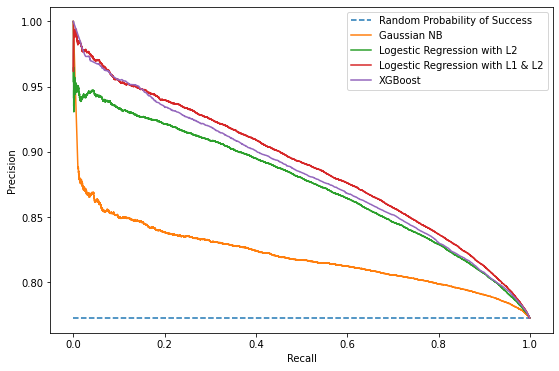

In [ ]:
def pr_curve(model_data):
  """Plotting the Precision-Recall curves"""
  plt.rcParams["figure.figsize"] = (9,6)
  # Line graph for each model
  no_skill = len(dev_label[dev_label==1]) / len(dev_label)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Probability of Success')
  for name in model_data:
    data = model_data[name]["data"]
    model = model_data[name]["model"]
    model.predict(data)
    fully_paid_probs = model.predict_proba(data)[:, 1]
    precision, recall, _ = precision_recall_curve(dev_label, fully_paid_probs)
    plt.plot(recall, precision, label=name)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

# Removing '<' character as XGBClassifier doesn't like it
dev_data.rename(columns={"emp_length=< 1 year": "emp_length=less 1 year"}, inplace=True)
dev_data_l1_l2 = scaled_dev_data.loc[:,best_features]
models = {"Gaussian NB": {"model":gaussian_nb_clf, "data":dev_data},
          "Logestic Regression with L2": {"model":lr_l2_clf,"data":scaled_dev_data},
          "Logestic Regression with L1 & L2":{"model":lr_l1_l2_clf,"data":dev_data_l1_l2},
          #"GMM Fully Paid": {"model": gmm_fully_paid_clf, "data": dev_data},
          #"GMM Charged Off": {"model": gmm_charged_off_clf, "data": dev_data},
          "XGBoost": {"model": xgb_clf, "data": dev_data}}
pr_curve(models)

In [ ]:
gmm_fully_paid_clf.predict_proba(dev_data)

array([[1.19881557e-26, 2.08530005e-53, 1.00000000e+00],
       [4.44620887e-20, 7.14752047e-49, 1.00000000e+00],
       [1.00000000e+00, 1.64184482e-30, 0.00000000e+00],
       ...,
       [1.00000000e+00, 3.15139784e-46, 0.00000000e+00],
       [1.67852636e-19, 2.76161959e-58, 1.00000000e+00],
       [1.00000000e+00, 1.02087362e-48, 0.00000000e+00]])

In [ ]:
gmm_charged_off_clf.predict_proba(dev_data)

array([[0.00000000e+00, 8.93435147e-37, 1.00000000e+00],
       [1.00000000e+00, 3.82996482e-64, 6.58288650e-41],
       [1.00000000e+00, 1.23305711e-64, 4.85641425e-38],
       ...,
       [1.00000000e+00, 2.11283692e-59, 0.00000000e+00],
       [1.00000000e+00, 9.14919009e-75, 2.15831612e-42],
       [1.00000000e+00, 3.29654119e-60, 0.00000000e+00]])

In [ ]:
dev_label

0        0.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
98547    1.0
98548    0.0
98549    1.0
98550    1.0
98551    1.0
Name: loan_status=Fully Paid, Length: 98552, dtype: float64

In [ ]:
gaussian_nb_clf.predict_proba(dev_data)

array([[0.90238809, 0.09761191],
       [0.72491863, 0.27508137],
       [0.85367456, 0.14632544],
       ...,
       [0.12222122, 0.87777878],
       [0.6629259 , 0.3370741 ],
       [0.70565793, 0.29434207]])